In [3]:
import numpy as np
import matplotlib.pyplot as plt
from gwsnr import GWSNR

In [4]:
# initializing the GWSNR class with default configuration and interpolation method
# for aligned-spinning IMRPhenomD waveform
gwsnr = GWSNR(
    npool=8,
    snr_type='interpolation_aligned_spins', # or 'interpolation_aligned_spins_jax'
    gwsnr_verbose=False,
)


Initializing GWSNR class...

psds not given. Choosing bilby's default psds
Interpolator will be loaded for L1 detector from ./interpolator_pickle/L1/partialSNR_dict_0.pickle
Interpolator will be loaded for H1 detector from ./interpolator_pickle/H1/partialSNR_dict_0.pickle
Interpolator will be loaded for V1 detector from ./interpolator_pickle/V1/partialSNR_dict_0.pickle




In [12]:
idx = [gwsnr.mtot_arr[0:4], gwsnr.ratio_arr[-1], gwsnr.a_1_arr[-1], gwsnr.a_2_arr[-1]]

In [33]:
gwsnr.mtot_arr.shape, gwsnr.ratio_arr.shape, gwsnr.a_1_arr.shape, gwsnr.a_2_arr.shape

((200,), (20,), (10,), (10,))

In [39]:
m, q, a1, a2, rho = gwsnr.mtot_arr[0:4], gwsnr.ratio_arr[5], gwsnr.a_1_arr[-1], gwsnr.a_2_arr[-1], gwsnr.snr_partialsacaled_list[0, 5, 0:4, -1, -1]
print(f"m = {m}, q = {q}, a1 = {a1}, a2 = {a2}, rho = {rho}")

m = [ 9.96       13.66335837 17.30835561 20.89591145], q = 0.18329807108324356, a1 = 0.99, a2 = 0.99, rho = [2813.90795898 2804.67456055 2800.70898438 2801.99536133]


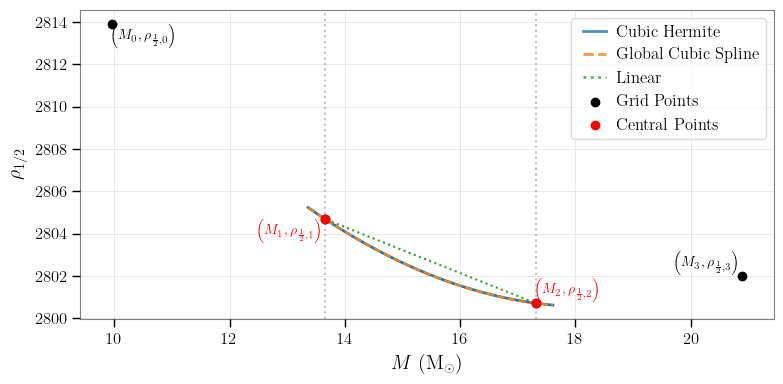

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline, interp1d
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],    
    "font.size": 12
})

# Grid points (example, not equally spaced)
M = gwsnr.mtot_arr[0:4]
rho = gwsnr.snr_partialsacaled_list[0, 5, 0:4, -1, -1]

# The interval of interpolation
M1, M2 = M[1], M[2]
rho1, rho2 = rho[1], rho[2]
h = M2 - M1

# Finite difference derivatives
def finite_diff(M, rho):
    # Slope at M1
    m1 = ((M[2] - M[1])/(M[2] - M[0])) * (rho[2] - rho[1])/(M[2] - M[1]) \
       + ((M[1] - M[0])/(M[2] - M[0])) * (rho[1] - rho[0])/(M[1] - M[0])
    # Slope at M2
    m2 = ((M[2] - M[1])/(M[3] - M[1])) * (rho[2] - rho[1])/(M[2] - M[1]) \
       + ((M[3] - M[2])/(M[3] - M[1])) * (rho[3] - rho[2])/(M[3] - M[2])
    return m1, m2

m1, m2 = finite_diff(M, rho)

# Hermite interpolation function
def hermite_interp(M_new):
    t = (M_new - M1) / h
    h00 = 2*t**3 - 3*t**2 + 1
    h10 = t**3 - 2*t**2 + t
    h01 = -2*t**3 + 3*t**2
    h11 = t**3 - t**2
    return h00*rho1 + h10*m1*h + h01*rho2 + h11*m2*h

# For comparison: cubic spline and linear interpolations
cs = CubicSpline(M, rho)
li = interp1d(M, rho)

# Plot range
M_fine = np.linspace(M1-0.3, M2+0.3, 200)
rho_hermite = hermite_interp(M_fine)
rho_cubic = cs(M_fine)
rho_linear = li(M_fine[(M_fine >= M1) & (M_fine <= M2)])

# Create the figure
plt.figure(figsize=(8,4))
plt.plot(M_fine, rho_hermite, label="Cubic Hermite", color='C0', lw=2)
plt.plot(M_fine, rho_cubic, '--', label="Global Cubic Spline", color='C1')
plt.plot(M_fine[(M_fine >= M1) & (M_fine <= M2)], rho_linear, ':', label="Linear", color='C2')
plt.scatter(M, rho, c='k', zorder=10, label="Grid Points")
plt.scatter([M1, M2], [rho1, rho2], color='r', zorder=11, label="Central Points")
plt.xlabel("$M$ (M$_\odot$)")
plt.ylabel(r"$\rho_{1/2}$")
plt.axvline(M1, ls=':', color='gray', alpha=0.5)
plt.axvline(M2, ls=':', color='gray', alpha=0.5)

# labeling points (M_0, \rho_{\frac{1}{2},0})$, $(M_1, \rho_{\frac{1}{2},1})$, $(M_2, \rho_{\frac{1}{2},2})
# plt.text(M1, rho1, r"$\left(M_1, \rho_{\frac{1}{2},1}\right)$", fontsize=10, ha='right', va='top', color='r')
# plt.text(M2, rho2, r"$\left(M_2, \rho_{\frac{1}{2},2}\right)$", fontsize=10, ha='left', va='top', color='r')
plt.text(M[0], rho[0], r"$\left(M_0, \rho_{\frac{1}{2},0}\right)$", fontsize=10, ha='left', va='top', color='k')
plt.text(M[1], rho[1], r"$\left(M_1, \rho_{\frac{1}{2},1}\right)$", fontsize=10, ha='right', va='top', color='r')
plt.text(M[2], rho[2], r"$\left(M_2, \rho_{\frac{1}{2},2}\right)$", fontsize=10, ha='left', va='bottom', color='r')
plt.text(M[3], rho[3], r"$\left(M_3, \rho_{\frac{1}{2},3}\right)$", fontsize=10, ha='right', va='bottom', color='k')

legend = plt.legend(handlelength=2, loc='upper right', bbox_to_anchor=(1.0, 1.0), frameon=True, fontsize=12, edgecolor='lightgray')
legend.get_frame().set_boxstyle('Round', pad=0.0, rounding_size=0.2)
# Modify line width for legend entries
for handle in legend.get_lines():
    handle.set_linewidth(2)
    handle.set_alpha(0.8)


plt.grid(alpha=0.4)
plt.tight_layout()
plt.savefig("../_static/hermite_interpolation_example.png", dpi=300)
plt.show()
